# Setup of Noteboook

The follwing code clones the github repository with course files. 
Subsequently it imports all libraries and custom modules needed for this notebook

In [ ]:
!git clone https://github.com/DataHow/analytics-course-scripts.git
!pip install --upgrade scipy==1.7.3

In [18]:
# import libraries
from scipy.stats import qmc
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

# Hybrid Models

A simple model for cell expansion, accounting for the growth of viable cell density (VCD) and the consumption of glucose (Glc), is used to show how hybrid models are trained and can predict new experimental conditions.

In [19]:
def ode_fcn(t, y, feed):
  # define parameters
    VCD = y[0]
    Glc = y[1]
    # growth rate
    mu = Glc/(5+Glc)
    # mass balances
    dVCD_dt = mu*VCD
    dGlc_dt = -(0.5*mu+0.05*Glc)*VCD+feed
    dy = [dVCD_dt, dGlc_dt]
    return dy

def run_experiment(VCD_0, Glc_0, feed, t_end):
    fun = lambda t, y: ode_fcn(t,y,feed)
    y0 = [VCD_0, Glc_0]
    t_span = np.arange(0, 0.5*round(2*t_end)+0.25, 0.25)
    sol = solve_ivp(fun, [t_span[0], t_span[-1]], y0, method='LSODA', t_eval=t_span, rtol=1e-6, atol=1e-6)
    t = sol.t.tolist()
    y = sol.y.T
    VCD = y[:, 0]
    Glc = y[:, 1]
    return t, VCD, Glc


In [20]:
def ode_fcn_1st_hybrid(t, y, feed, g_mld, k_mld):
    # mass balances
    dVCD_dt = g_mld.predict(y.reshape(-1, 1).T)
    dGlc_dt = -k_mld.predict(y.reshape(-1, 1).T) + feed
    return [dVCD_dt, dGlc_dt]


def run_1st_hybrid(VCD_0, Glc_0, feed, t_end, g_mld, k_mld):
    fun = lambda t, y: ode_fcn_1st_hybrid(t, y, feed, g_mld, k_mld)
    y0 = np.array([VCD_0, Glc_0])
    t_span = np.arange(0, 0.5 * round(2 * t_end) + 0.25, 0.25)
    sol = solve_ivp(fun, [t_span[0], t_span[-1]], y0, method='LSODA', t_eval=t_span, rtol=1e-6, atol=1e-6)
    t = sol.t.tolist()
    y = sol.y.T
    VCD = y[:, 0]
    Glc = y[:, 1]
    return t, VCD, Glc

In [21]:
def ode_fcn_2nd_hybrid(t, y,feed, g_mld,k_mld):
    # mass balances
    dVCD_dt = g_mld.predict(y.reshape(-1, 1).T)*y[0]
    dGlc_dt = -k_mld.predict(y.reshape(-1, 1).T)*y[0]+feed
    return [dVCD_dt, dGlc_dt]


def run_2nd_hybrid(VCD_0,Glc_0,feed,t_end,mu_mld,k_mld):
    fun = lambda t, y: ode_fcn_2nd_hybrid(t, y, feed, g_mld, k_mld)
    y0 = np.array([VCD_0, Glc_0])
    t_span = np.arange(0, 0.5 * round(2 * t_end) + 0.25, 0.25)
    sol = solve_ivp(fun, [t_span[0], t_span[-1]], y0, method='LSODA', t_eval=t_span, rtol=1e-6, atol=1e-6)
    t = sol.t.tolist()
    y = sol.y.T
    VCD = y[:, 0]
    Glc = y[:, 1]
    return t, VCD, Glc

# Hybrid Models

A simple model for cell expansion, accounting for the growth of viable cell density (VCD) and the consumption of glucose (Glc), is used to show how hybrid models are trained and can predict new experimental conditions.

Firstly, we will run the base experiment experiment:

## Run base experiment

Here we create work with the same insilico model as before. The cell process parameters which we are able to design are following:

*   `VCD_0` Amount of VCD at time 0
*   `Glc_0` Amount of Glc at time 0
*   `feed_rate` Amount of continuous feed each day. Feeding starts at day 1.
*   `feed_end` Day when we stop feeding. This defines aslo the length of experiment.

Subsequently we plot the process evolution over time.


In [22]:
# Set CPP's for run generation
VCD_0 = 0.5
Glc_0 = 10
feed_rate = 10
feed_end = 5

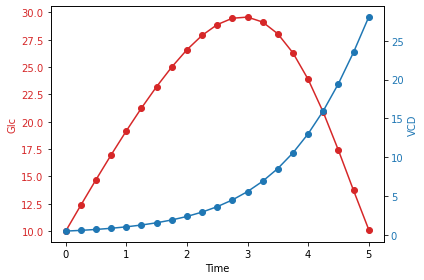

In [23]:
# Plot base experiment run
t, VCD, Glc = run_experiment(VCD_0,Glc_0,feed_rate,feed_end)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Glc', color=color)
ax1.plot(t, Glc, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('VCD', color=color)  # we already handled the x-label with ax1
ax2.plot(t, VCD, 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Create experimental design

Here we create a diverse set of experimental conditions for cell process parameters using Latin Hypercube Sampling and run the experiments.


In [24]:
# Define number of experiments
Nruns_train = 4
# Define initial conditions for process parameters
DoE_train = np.zeros((Nruns_train,3))
sampler = qmc.LatinHypercube(d=3)
DoE_nondim_train = 2*sampler.random(n=Nruns_train)-1
DoE_train[:, 0] = 2+1.5*DoE_nondim_train[:,0]   # VCD_0
DoE_train[:, 1] = 20+10*DoE_nondim_train[:,1]   # Glc_0
DoE_train[:, 2] = 30+25*DoE_nondim_train[:,2]   # feed_rate

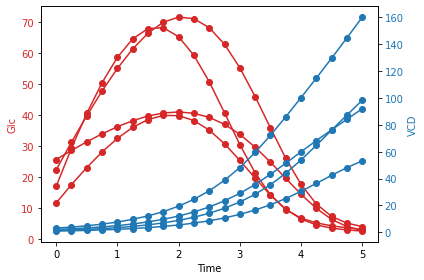

In [25]:
# Run experiments
VCD = np.zeros((21, Nruns_train))
Glc = np.zeros((21, Nruns_train))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for nexp in range(Nruns_train):
    t, VCD[:,nexp],Glc[:,nexp] = run_experiment(DoE_train[nexp,0],DoE_train[nexp,1],DoE_train[nexp,2],5)
    
    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Glc', color=color)
    ax1.plot(t, Glc[:, nexp], 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    color = 'tab:blue'
    ax2.set_ylabel('VCD', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, VCD[:, nexp], 'o-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Create test set

In similar fashion we create a test set significantly larger number of experiments to properly verify the model's performance on a completely unsees data.

In [26]:
# Define number of experiments
Nruns_test = 100
# Define initial conditions for process parameters
DoE_test = np.zeros((Nruns_test,3))
sampler = qmc.LatinHypercube(d=3)
DoE_nondim_test = 2*sampler.random(n=Nruns_test)-1
DoE_test[:, 0] = 2+1.5*DoE_nondim_test[:,0]   # VCD_0
DoE_test[:, 1] = 20+10*DoE_nondim_test[:,1]   # Glc_0
DoE_test[:, 2] = 30+25*DoE_nondim_test[:,2]   # feed_rate
DoE_test.shape

# Run experiments
VCD_test = np.zeros((21, Nruns_test))
Glc_test = np.zeros((21, Nruns_test))
for nexp in range(Nruns_test):
    t, VCD_test[:,nexp], Glc_test[:,nexp] = run_experiment(DoE_test[nexp,0],DoE_test[nexp,1], DoE_test[nexp,2],5)


## Train Black-box GP
In this section, we are training a "black-box" Gaussian process, which is directly linking the manipulated variables to the final VCD and the final Glc.

The scope of this exercize is to show that the good predictability of the hybrid models that are shown below in the script cannot be ascribed to the fitting capabilities of GPs or any other model with such few experiments.

We create a models to predict final VCD, final Glc, and also Glucose at mid-point.

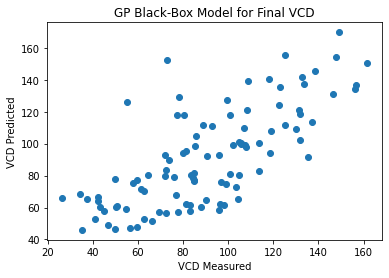

In [31]:
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0, n_restarts_optimizer=3).fit(DoE_train, VCD[20, :])
Glc_end_pred = gpr.predict(DoE_test)
plt.scatter(VCD_test[20,:], Glc_end_pred)
plt.ylabel('VCD Predicted')
plt.xlabel('VCD Measured')
plt.title('GP Black-Box Model for Final VCD')
plt.show()

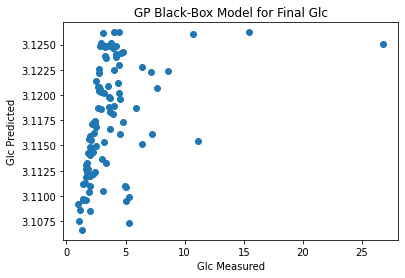

In [32]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=3).fit(DoE_train, Glc[20,:])
Glc_end_pred = gpr.predict(DoE_test)
plt.scatter(Glc_test[20,:], Glc_end_pred)
plt.ylabel('Glc Predicted')
plt.xlabel('Glc Measured')
plt.title('GP Black-Box Model for Final Glc')
plt.show()

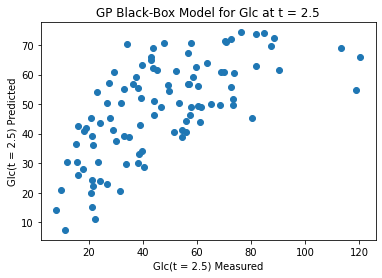

In [33]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=3).fit(DoE_train, Glc[10,:])
Glc_end_pred = gpr.predict(DoE_test)
plt.scatter(Glc_test[10,:], Glc_end_pred)
plt.ylabel('Glc(t = 2.5) Predicted')
plt.xlabel('Glc(t = 2.5) Measured')
plt.title('GP Black-Box Model for Glc at t = 2.5')
plt.show()

We can see that the models can learn the mean prediction but are having hard time in various process parameter settings.

## First Hybrid Model  

Let's suppose the following model: 

$$
\begin{aligned}
&\frac{\mathrm{dVCD}}{\mathrm{dt}}=g(\mathrm{VCD}, \mathrm{Glc}) \\
&\frac{\mathrm{dGlc}}{\mathrm{dt}}=-k(\mathrm{VCD}, \mathrm{Glc})+\text { feed }
\end{aligned}
$$

Let's use the inverse method to get the model. First, let's estimate the derivatives.


### Find and model derivatives

In [34]:
# Estimating derivatives (changes/deltas)
g = np.zeros((21, Nruns_train))
k = np.zeros((21, Nruns_train))
delta_t = t[1]-t[0]
g[0,:] = (VCD[1,:]-VCD[0,:])/delta_t
dGlcdt = (Glc[1,:]-Glc[0,:])/delta_t
k[0,:] = -dGlcdt+DoE_train[:,2].T
for nstep in range(1, 20):
    g[nstep,:] = 0.5*(VCD[nstep+1,:]-VCD[nstep-1,:])/delta_t
    dGlcdt = 0.5*(Glc[nstep+1,:]-Glc[nstep-1,:])/delta_t
    k[nstep,:] = -dGlcdt+DoE_train[:,2].T
g[20,:] = (VCD[20,:]-VCD[19,:])/delta_t
dGlcdt = (Glc[20,:]-Glc[19,:])/delta_t
k[20,:] = -dGlcdt+DoE_train[:,2].T

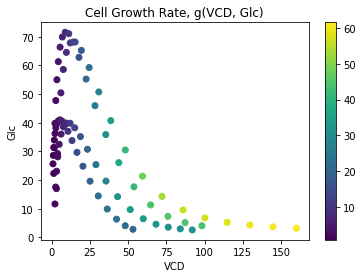

In [35]:
# Plot of derivatives for VCD
plt.scatter(VCD.flatten(), Glc.flatten(), c=g.flatten(), cmap='viridis')
plt.ylabel('Glc')
plt.xlabel('VCD')
plt.title('Cell Growth Rate, g(VCD, Glc)')
plt.colorbar()
plt.show()

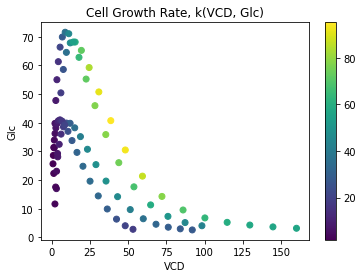

In [36]:
# Plot of derivatives for Glc
plt.scatter(VCD.flatten(), Glc.flatten(), c=k.flatten(), cmap='viridis')
plt.ylabel('Glc')
plt.xlabel('VCD')
plt.title('Cell Growth Rate, k(VCD, Glc)')
plt.colorbar()
plt.show()

Let's fit a model to those derivatives:

In [37]:
X = np.stack((VCD.flatten(), Glc.flatten()), axis=1)
g_mld = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.0, n_restarts_optimizer=3).fit(X, g.flatten())
k_mld = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.0, n_restarts_optimizer=3).fit(X, k.flatten())

### Prediction on train set

Make prediction on the training set:

In [38]:
VCD_train_pred = np.zeros((21, Nruns_train))
Glc_train_pred = np.zeros((21, Nruns_train))
for nexp in range(Nruns_train):
    t,VCD_train_pred[:,nexp],Glc_train_pred[:,nexp] = run_1st_hybrid(DoE_train[nexp,0], DoE_train[nexp,1], DoE_train[nexp,2], 5, g_mld, k_mld)

Plot the fit of our model on a training experiment (1st hybrid):

In [47]:
# Select experiment on which to compare
exp_no = 1

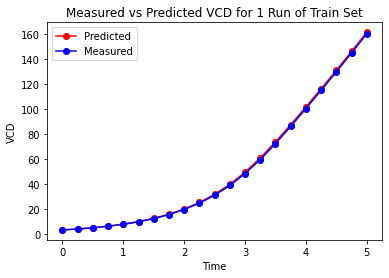

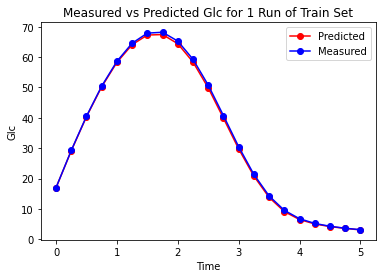

In [48]:
plt.plot(t, VCD_train_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, VCD[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('VCD')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted VCD for 1 Run of Train Set')
plt.show()

plt.plot(t, Glc_train_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, Glc[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('Glc')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted Glc for 1 Run of Train Set')
plt.show()

Plot observed vs predicted in the training set for all times (1st hybrid):

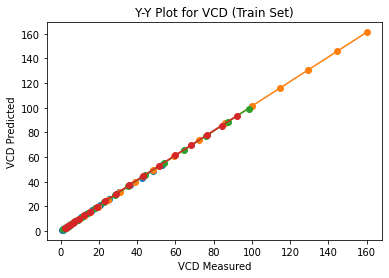

In [49]:
for nexp in range(Nruns_train):
    plt.plot(VCD[:, nexp],VCD_train_pred[:, nexp], 'o-')
    
plt.ylabel('VCD Predicted')
plt.xlabel('VCD Measured')
plt.title('Y-Y Plot for VCD (Train Set)')
plt.show()

In [53]:
RMSE_VCD = np.sqrt(np.sum((VCD.flatten()-VCD_train_pred.flatten())**2)/Nruns_train)
print("Absolute RMSE: ",RMSE_VCD)
RMSE_VCD_rel = RMSE_VCD/np.std(VCD.flatten())
print("Relative RMSE: ",RMSE_VCD_rel)

Absolute RMSE:  3.729323369133644
Relative RMSE:  0.10375877360858844


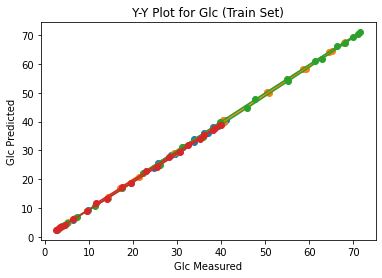

In [54]:
for nexp in range(Nruns_train):
    plt.plot(Glc[:, nexp],Glc_train_pred[:, nexp], 'o-')
    
plt.ylabel('Glc Predicted')
plt.xlabel('Glc Measured')
plt.title('Y-Y Plot for Glc (Train Set)')
plt.show()

In [55]:
RMSE_Glc = np.sqrt(np.sum((Glc.flatten()-Glc_train_pred.flatten())**2)/Nruns_train)
print("Absolute RMSE: ",RMSE_Glc)
RMSE_Glc_rel = RMSE_Glc/np.std(Glc.flatten())
print("Relative RMSE: ",RMSE_Glc_rel)

Absolute RMSE:  3.054936581908383
Relative RMSE:  0.14984208422823483


### Prediction on test set

Make prediction on the test set (1st hybrid):

In [56]:
VCD_test_pred = np.zeros((21,Nruns_test))
Glc_test_pred = np.zeros((21,Nruns_test))
for nexp in range(Nruns_test):
    t, VCD_test_pred[:,nexp], Glc_test_pred[:,nexp] = run_1st_hybrid(DoE_test[nexp,0], DoE_test[nexp,1], DoE_test[nexp,2], 5, g_mld, k_mld)


Plot how the trained model fits on a test experiment (1st hybrid):

In [57]:
# Select experiment on which to compare
exp_no = 1

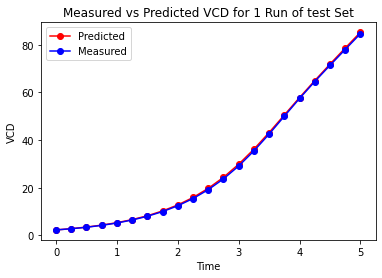

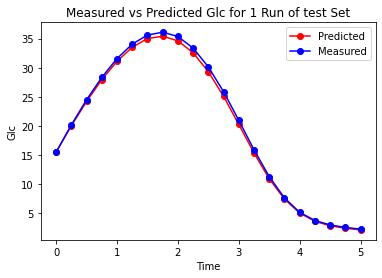

In [58]:
plt.plot(t, VCD_test_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, VCD_test[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('VCD')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted VCD for 1 Run of test Set')
plt.show()

plt.plot(t, Glc_test_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, Glc_test[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('Glc')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted Glc for 1 Run of test Set')
plt.show()

Plot YvsY in test set for all times (1st hybrid):

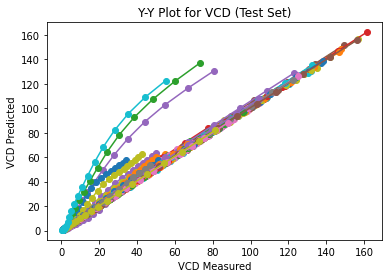

In [59]:
for nexp in range(Nruns_test):
    plt.plot(VCD_test[:, nexp], VCD_test_pred[:, nexp], 'o-')
    
plt.ylabel('VCD Predicted')
plt.xlabel('VCD Measured')
plt.title('Y-Y Plot for VCD (Test Set)')
plt.show()

In [60]:
RMSE_VCD = np.sqrt(np.sum((VCD_test.flatten()-VCD_test_pred.flatten())**2)/Nruns_test)
print("Absolute RMSE: ",RMSE_VCD)
RMSE_VCD_rel = RMSE_VCD/np.std(VCD_test.flatten())
print("Relative RMSE: ",RMSE_VCD_rel)

Absolute RMSE:  26.590675873912108
Relative RMSE:  0.8428007619478085


RMSE of 0.85 doesn't seem to be good, however we can see that for majority of the experiments the model predictions are in line with observations. However few experiments which were likely very different conditions than our train set.

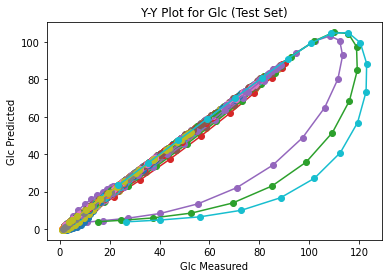

In [61]:
for nexp in range(Nruns_test):
    plt.plot(Glc_test[:, nexp], Glc_test_pred[:, nexp], 'o-')
    
plt.ylabel('Glc Predicted')
plt.xlabel('Glc Measured')
plt.title('Y-Y Plot for Glc (Test Set)')
plt.show()

In [62]:
RMSE_Glc = np.sqrt(np.sum((Glc_test.flatten()-Glc_test_pred.flatten())**2)/Nruns_test)
print("Absolute RMSE: ",RMSE_Glc)
RMSE_Glc_rel = RMSE_Glc/np.std(Glc_test.flatten())
print("Relative RMSE: ",RMSE_Glc_rel)

Absolute RMSE:  26.494437855285977
Relative RMSE:  1.1291458182560685


We observe a similar situation in Glucose.

## Second Hybrid Model

Let's suppose the following model:
$$
\begin{aligned}
&\frac{\mathrm{dVCD}}{\mathrm{dt}}=\mu(\mathrm{VCD}, \mathrm{Glc}) \cdot \mathrm{VCD} \\
&\frac{\mathrm{dGlc}}{\mathrm{dt}}=-k(\mathrm{VCD}, \mathrm{Glc}) \cdot \mathrm{VCD}+\text { feed }
\end{aligned}
$$

As before, let's use the inverse method to get the model. First, let's estimate the derivatives.

### Find and model derivatives

In [63]:
g = np.zeros((21,Nruns_train))
k = np.zeros((21,Nruns_train))
delta_t = t[1]-t[0]
dVCDdt = (VCD[1,:]-VCD[0,:])/delta_t
g[0,:] = dVCDdt/VCD[0,:]
dGlcdt = (Glc[1,:]-Glc[0,:])/delta_t
k[0,:] = (-dGlcdt+DoE_train[:,2].T)/VCD[1,:]
for nstep in range(1,20):
    dVCDdt = 0.5*(VCD[nstep+1,:]-VCD[nstep-1,:])/delta_t
    g[nstep,:] = dVCDdt/VCD[nstep,:]
    dGlcdt = 0.5*(Glc[nstep+1,:]-Glc[nstep-1,:])/delta_t
    k[nstep,:] = (-dGlcdt+DoE_train[:,2].T)/VCD[nstep,:]
dVCDdt = (VCD[20,:]-VCD[19,:])/delta_t
g[20,:] = dVCDdt/VCD[20,:]
dGlcdt = (Glc[20,:]-Glc[19,:])/delta_t
k[20,:] = (-dGlcdt+DoE_train[:,2].T)/VCD[20,:]

Let's plot the data:

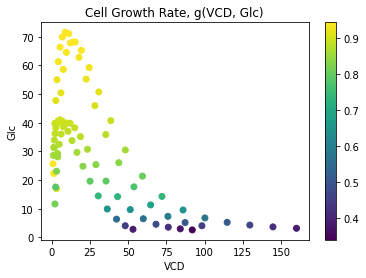

In [64]:
plt.scatter(VCD.flatten(), Glc.flatten(), c=g.flatten(), cmap='viridis')
plt.ylabel('Glc')
plt.xlabel('VCD')
plt.title('Cell Growth Rate, g(VCD, Glc)')
plt.colorbar()
plt.show()

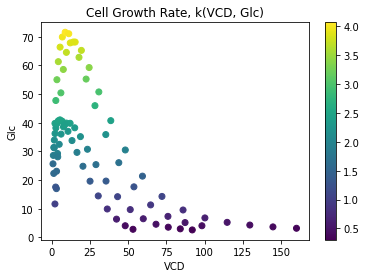

In [65]:
plt.scatter(VCD.flatten(), Glc.flatten(), c=k.flatten(), cmap='viridis')
plt.ylabel('Glc')
plt.xlabel('VCD')
plt.title('Cell Growth Rate, k(VCD, Glc)')
plt.colorbar()
plt.show()

Let's fit a model:

In [66]:
X = np.stack((VCD.flatten(), Glc.flatten()), axis=1)
g_mld = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.0, n_restarts_optimizer=3).fit(X, g.flatten())
k_mld = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.0, n_restarts_optimizer=3).fit(X, k.flatten())

### Prediction on train set

Make prediction on the training set:

In [67]:
VCD_train_pred = np.zeros((21, Nruns_train))
Glc_train_pred = np.zeros((21, Nruns_train))
for nexp in range(Nruns_train):
    t, VCD_train_pred[:,nexp], Glc_train_pred[:,nexp] = run_2nd_hybrid(DoE_train[nexp,0], DoE_train[nexp,1], DoE_train[nexp,2], 5, g_mld, k_mld)

Plot the fit of our model on a training experiment (2nd hybrid):

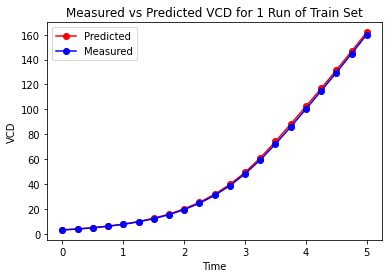

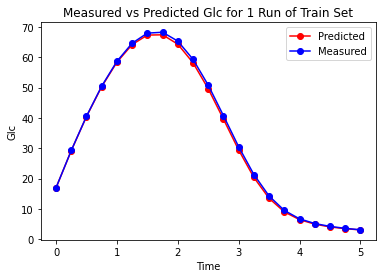

In [68]:
exp_no = 1
plt.plot(t, VCD_train_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, VCD[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('VCD')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted VCD for 1 Run of Train Set')
plt.show()

plt.plot(t, Glc_train_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, Glc[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('Glc')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted Glc for 1 Run of Train Set')
plt.show()

Plot YvsY in training set for all times (2nd hybrid):

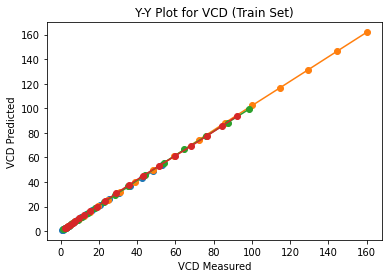

In [69]:
for nexp in range(Nruns_train):
    plt.plot(VCD[:, nexp],VCD_train_pred[:, nexp], 'o-')
    
plt.ylabel('VCD Predicted')
plt.xlabel('VCD Measured')
plt.title('Y-Y Plot for VCD (Train Set)')
plt.show()

In [72]:
RMSE_VCD = np.sqrt(np.sum((VCD.flatten()-VCD_train_pred.flatten())**2)/Nruns_train)
print("Absolute RMSE: ",RMSE_VCD)
RMSE_VCD_rel = RMSE_VCD/np.std(VCD.flatten())
print("Relative RMSE: ",RMSE_VCD_rel)


Absolute RMSE:  4.439872936979588
Relative RMSE:  0.12352797687961906


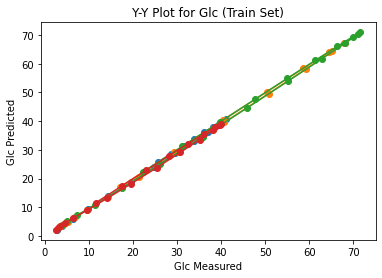

In [73]:
for nexp in range(Nruns_train):
    plt.plot(Glc[:, nexp],Glc_train_pred[:, nexp], 'o-')
    
plt.ylabel('Glc Predicted')
plt.xlabel('Glc Measured')
plt.title('Y-Y Plot for Glc (Train Set)')
plt.show()

In [74]:
RMSE_Glc = np.sqrt(np.sum((Glc.flatten()-Glc_train_pred.flatten())**2)/Nruns_train)
print("Absolute RMSE: ",RMSE_Glc)
RMSE_Glc_rel = RMSE_Glc/np.std(Glc.flatten())
print("Relative RMSE: ",RMSE_Glc_rel)


Absolute RMSE:  3.2678121937467552
Relative RMSE:  0.1602834549421553


### Prediction on test set

Make prediction on the test set (2nd hybrid):

In [75]:
VCD_test_pred = np.zeros((21,Nruns_test))
Glc_test_pred = np.zeros((21,Nruns_test))
for nexp in range(Nruns_test):
    t, VCD_test_pred[:,nexp], Glc_test_pred[:,nexp] = run_2nd_hybrid(DoE_test[nexp,0], DoE_test[nexp,1], DoE_test[nexp,2], 5, g_mld, k_mld)

Plot how the model fits on a test experiment (2nd hybrid):

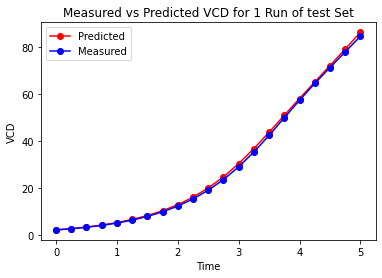

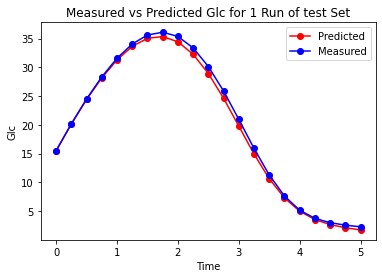

In [76]:
exp_no = 1
plt.plot(t, VCD_test_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, VCD_test[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('VCD')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted VCD for 1 Run of test Set')
plt.show()

plt.plot(t, Glc_test_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, Glc_test[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('Glc')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted Glc for 1 Run of test Set')
plt.show()

Plot YvsY in the test set for all times (2nd hybrid):

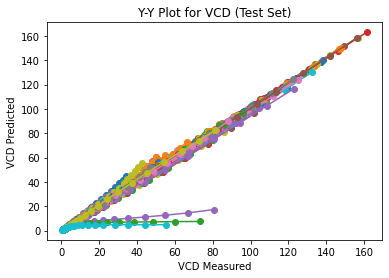

In [77]:
for nexp in range(Nruns_test):
    plt.plot(VCD_test[:, nexp], VCD_test_pred[:, nexp], 'o-')
    
plt.ylabel('VCD Predicted')
plt.xlabel('VCD Measured')
plt.title('Y-Y Plot for VCD (Test Set)')
plt.show()

In [80]:
RMSE_VCD = np.sqrt(np.sum((VCD_test.flatten()-VCD_test_pred.flatten())**2)/Nruns_test)
print("Absolute RMSE: ",RMSE_VCD)
RMSE_VCD_rel = RMSE_VCD/np.std(VCD_test.flatten())
print("Relative RMSE: ",RMSE_VCD_rel)


Absolute RMSE:  18.253982147874733
Relative RMSE:  0.5785663416665575


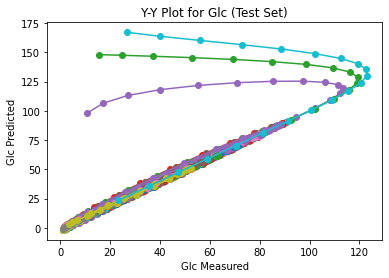

In [81]:
for nexp in range(Nruns_test):
    plt.plot(Glc_test[:, nexp], Glc_test_pred[:, nexp], 'o-')
    
plt.ylabel('Glc Predicted')
plt.xlabel('Glc Measured')
plt.title('Y-Y Plot for Glc (Test Set)')
plt.show()

In [82]:
RMSE_Glc = np.sqrt(np.sum((Glc_test.flatten()-Glc_test_pred.flatten())**2)/Nruns_test)
print("Absolute RMSE: ",RMSE_Glc)
RMSE_Glc_rel = RMSE_Glc/np.std(Glc_test.flatten())
print("Relative RMSE: ",RMSE_Glc_rel)

Absolute RMSE:  40.87952044724929
Relative RMSE:  1.7422124529475793


## Comparison